F:/seismic/models/brendan/*.pth
Loading:  F:/seismic/models/brendan\unet2d_caformer_seed3_epochbest.pt
n_models: 1


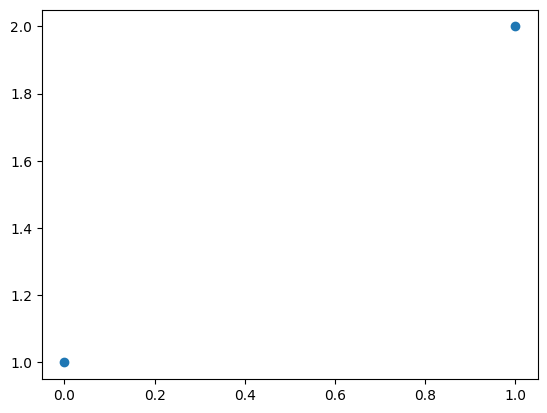

In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
kgs.preallocate_matrices=False
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_prior
import seis_model
import seis_forward2
plt.scatter([0,1],[1,2])
#fls.download_kaggle_dataset('jeroencottaar/byu-many-models-2/', fls.result_dir + '/many_full_res/')

In [2]:
importlib.reload(kgs)
data=kgs.load_all_train_data(validation_only=True)
print(len(data))
for d in data:
    d.check_constraints()
import seis_nn
model = seis_nn.default_pretrained
data = model.infer(data)

5000


Importing cache brendan: 100%|███████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 6187.61it/s]


In [4]:
vals_not = []
vals_styleA = []
vals_styleB = []
prior = seis_model.default_model().models[1].model_Style_A.prior
prior.transform = False
prior.prepped = False
prior.prep()
from tqdm import tqdm
import cupy as cp
for d in tqdm(data):
    #d.load_to_memory()
    dd = d#odel.infer([d])[0]
    dd.velocity_guess.to_cupy()
    x = dd.velocity_guess.to_vector()        
    kpi = np.log(cp.asnumpy(x[:-1,:].T@(prior.P)@x[:-1,:])[0,0])
    #kpi = cp.asnumpy(kgs.rms(d.seismogram.data[0,...] - cp.flip(d.seismogram.data[4,...],axis=1)))
    if 'Style_A' in d.family:
        vals_styleA.append(kpi)
    elif 'Style_B' in d.family:
        vals_styleB.append(kpi)
    else:
        vals_not.append(kpi)
    dd.velocity_guess.unload()
    dd.unload()
    d.unload()

styleB not active yet


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:11<00:00, 430.44it/s]


(14.346827482929072, 18.60168409037456, 12.763022885131255)

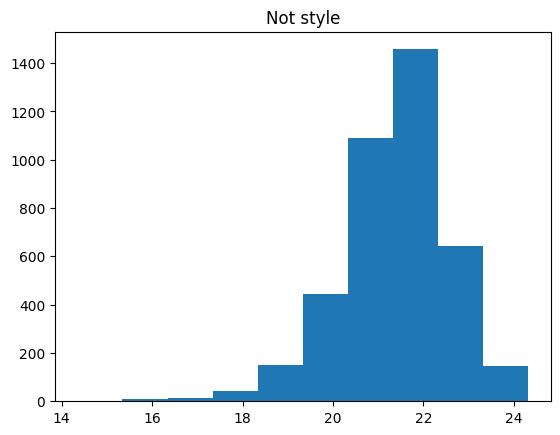

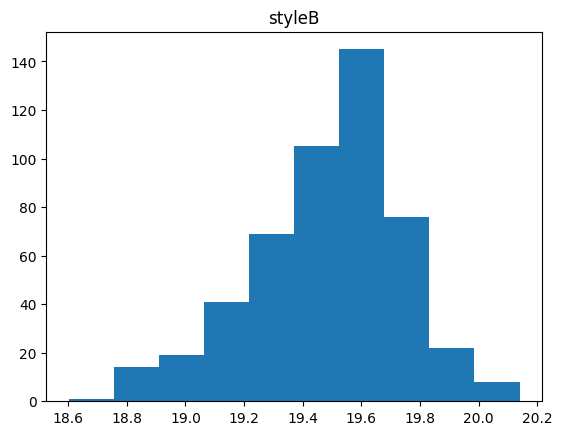

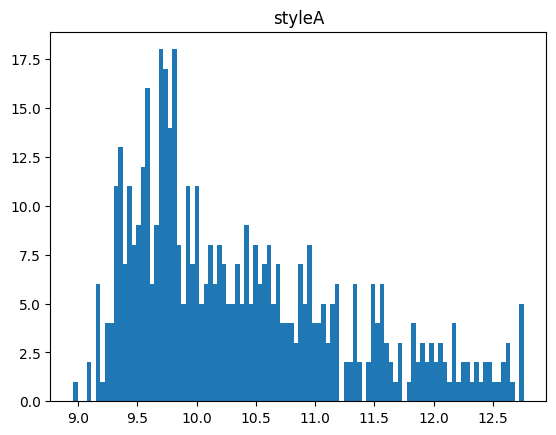

In [11]:
plt.figure()
plt.hist(vals_not)
plt.title('Not style')
plt.figure()
plt.hist(vals_styleB)
plt.title('styleB')
plt.figure()
plt.hist(vals_styleA, bins=100)
plt.title('styleA')
np.min(vals_not), np.min(vals_styleB), np.max(vals_styleA)

In [9]:
np.sum(cp.array(vals_not)<15)

array(2)

In [7]:
data[1].seismogram

Seismogram(filename='f:/seismic/data//train_samples\\CurveFault_A/seis2_1_0.npy', ind=1, data=None)